# Series Temporales

## Introducción

Una serie temporal se define como una colección de observaciones de una variable
recogidas secuencialmente en el tiempo. Estas observaciones se suelen recoger en instantes
de tiempo equiespaciados. Si los datos se recogen en instantes temporales de forma
continua, se debe o bien digitalizar la serie, es decir, recoger sólo los valores en instantes
de tiempo equiespaciados, o bien acumular los valores sobre intervalos de tiempo.


Aparecen en numerosos campos. Ejemplos:

Economía y Marketing
- Precio del alquiler de pisos durante una serie de meses.
- Evolución del índice del precio del trigo con mediciones anuales.
- Beneficios netos mensuales de cierta entidad bancaria.
- Indices del precio del petróleo.

Demografía
- Número de habitantes en cierto país por año.
- Tasa de mortalidad infantil por año.

Medioambiente
- Evolución horaria de niveles de óxido de azufre y de niveles de óxido de nitrógeno en una ciudad durante una serie de años.
- Lluvia recogida diariamente en una localidad.
- Temperatura media mensual.
- Medición diaria del contenido en residuos tóxicos en un río.


La característica fundamental de las series temporales es que las observaciones sucesivas no son independientes entre sí, y el análisis debe llevarse a cabo teniendo en cuenta el orden temporal de las observaciones. Los métodos estadísticos basados en la independencia de las observaciones no son válidos para el análisis de series temporales porque las observaciones en un instante de tiempo dependen de los valores de la serie en el pasado.

Una serie temporal puede ser discreta o continua dependiendo de cómo sean las observaciones. Si se pueden predecir exactamente los valores, se dice que las series son determinísticas. Si el futuro sólo se puede determinar de modo parcial por las observaciones pasadas y no se pueden determinar exactamente, se considera que los futuros valores tienen una distribución de probabilidad que está condicionada a los valores pasados. Las series son así estocásticas.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
#Graficos interactivos

import chart_studio.plotly as py
import plotly.io as pio
import plotly.express as px



In [16]:
#Cosas de Series temporales
import statsmodels.api as sm

#test de estacionariedad
from statsmodels.tsa.stattools import adfuller, kpss

##  Análisis

Cuando se estudia una serie temporal, lo primero que se tiene que hacer es dibujarla
y considerar las medidas descriptivas básicas. Así, se tiene que considerar:
    
    a) Si los datos presentan forma creciente (tendencia).
    
    b) Si existe influencia de ciertos periodos de cualquier unidad de tiempo (estacionalidad).
    
    c) Si aparecen outliers (observaciones extrañas o discordantes).

In [17]:
airpassengers = pd.read_csv('./Data/AirPassengers.csv')
airpassengers.head()

,TravelDate,Passengers
0,1/1/1949,112
1,2/1/1949,118
2,3/1/1949,132
3,4/1/1949,129
4,5/1/1949,121


Como siempre, chequeamos nuestro data set para ver si hay algún valor vacío o algo que no cuadre

In [18]:
airpassengers.isnull().sum()

TravelDate    0
Passengers    0
dtype: int64

Como podemos ver, no tenemos ningún valor vacío en nuestro conjunto de datos, por lo que somos libres de continuar nuestro análisis. Ahora, lo que haremos es confirmar que la columna TravelDate está en formato de fecha y hora y no en string. El atributo .dtypes del DataFrame hace esto posible.

In [19]:
airpassengers.dtypes

TravelDate    object
Passengers     int64
dtype: object

Podemos ver que la columna TravelDate es de un tipo de objeto genérico que podría ser una string. Dado que queremos realizar acciones relacionadas con el tiempo en estos datos, debemos convertirlo a un formato de fecha y hora antes de que pueda sernos útil. APara ello está la función to_datetime():

In [20]:
#Esto es crear un Timestamp
airpassengers['TravelDate'] = pd.to_datetime(airpassengers['TravelDate'])
airpassengers.head()

,TravelDate,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [21]:
airpassengers.dtypes

TravelDate    datetime64[ns]
Passengers             int64
dtype: object

Ahora, necesitamos establecer el objeto de fecha y hora como el índice del DataFrame para permitirnos realmente explorar nuestros datos. Para ello, usamos el método .set_index ():

In [22]:
airpassengers = airpassengers.set_index('TravelDate')
airpassengers.head()

,Passengers
TravelDate,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Podemos ver que ya es el índice nuestra columna 'TravelDate'. Vamos a plotear la serie a ver qué podemos inferir.

In [101]:
#le paso reset index porque plotly express necesita las fechas en una columna
airpassengerspx = airpassengers.reset_index()
px.line(airpassengerspx,x="TravelDate", y="Passengers")

Vemos una tendencia al alza que indica que la aerolínea tendría más pasajeros con el tiempo. Aunque hay altibajos en cada momento, generalmente podemos observar que la tendencia aumenta. También podemos notar cómo los altibajos parecen ser un poco regulares, lo que significa que también podríamos estar observando un patrón estacional. Echemos un vistazo más de cerca al observar los datos de algunos años:

In [120]:
px.line(airpassengerspx[(airpassengerspx.TravelDate.dt.year >= 1959)], x="TravelDate", y="Passengers")

En el plot vemos que, generalmente, hay un pico entre julio y septiembre que comienza a caer en octubre, lo que implica que más personas viajan entre julio y septiembre y probablemente viajan menos a partir de octubre.

In [127]:
px.scatter(airpassengerspx,x="TravelDate", y="Passengers")

In [129]:
px.bar(airpassengerspx,x="TravelDate", y="Passengers")

In [141]:
#Creo la columna 'Year' para hacer boxplot anuales
airpassengerspx['Year'] = airpassengerspx['TravelDate'].dt.year

In [147]:
px.box(airpassengerspx, x="Year", y="Passengers")

COSAS DE VISUALIZACIÓN DE TIME SERIES EN PYTHON´´

https://machinelearningmastery.com/time-series-data-visualization-with-python/

## Descomposición

Podemos ir un poco más allá y seguir analizando el comportamiento de nuestra serie usando técnicas de descomposición para deconstruir nuestra observación en varios componentes, cada uno de los cuales representa una de las categorías subyacentes de patrones.

Podemos descomponer nuestra serie a través de dos modelos

1. Modelo aditivo: este modelo se utiliza cuando las variaciones alrededor de la tendencia no varían con el nivel de la serie temporal. Aquí los componentes de una serie temporal simplemente se suman usando la fórmula:
    y (t) = Nivel (t) + Tendencia (t) + Estacionalidad (t) + Ruido (t)


2. Modelo multiplicativo: se utiliza si la tendencia es proporcional al nivel de la serie temporal. Aquí los componentes de una serie temporal simplemente se multiplican usando la fórmula:
    y (t) = Nivel (t) * Tendencia (t) * Estacionalidad (t) * Ruido (t)
    
Para la descomposición de nuestra serie vamos a ver ambos modelos. Utilizaremos statsmodels donde se encuentra la función seasonal_decompose que necesitamos.

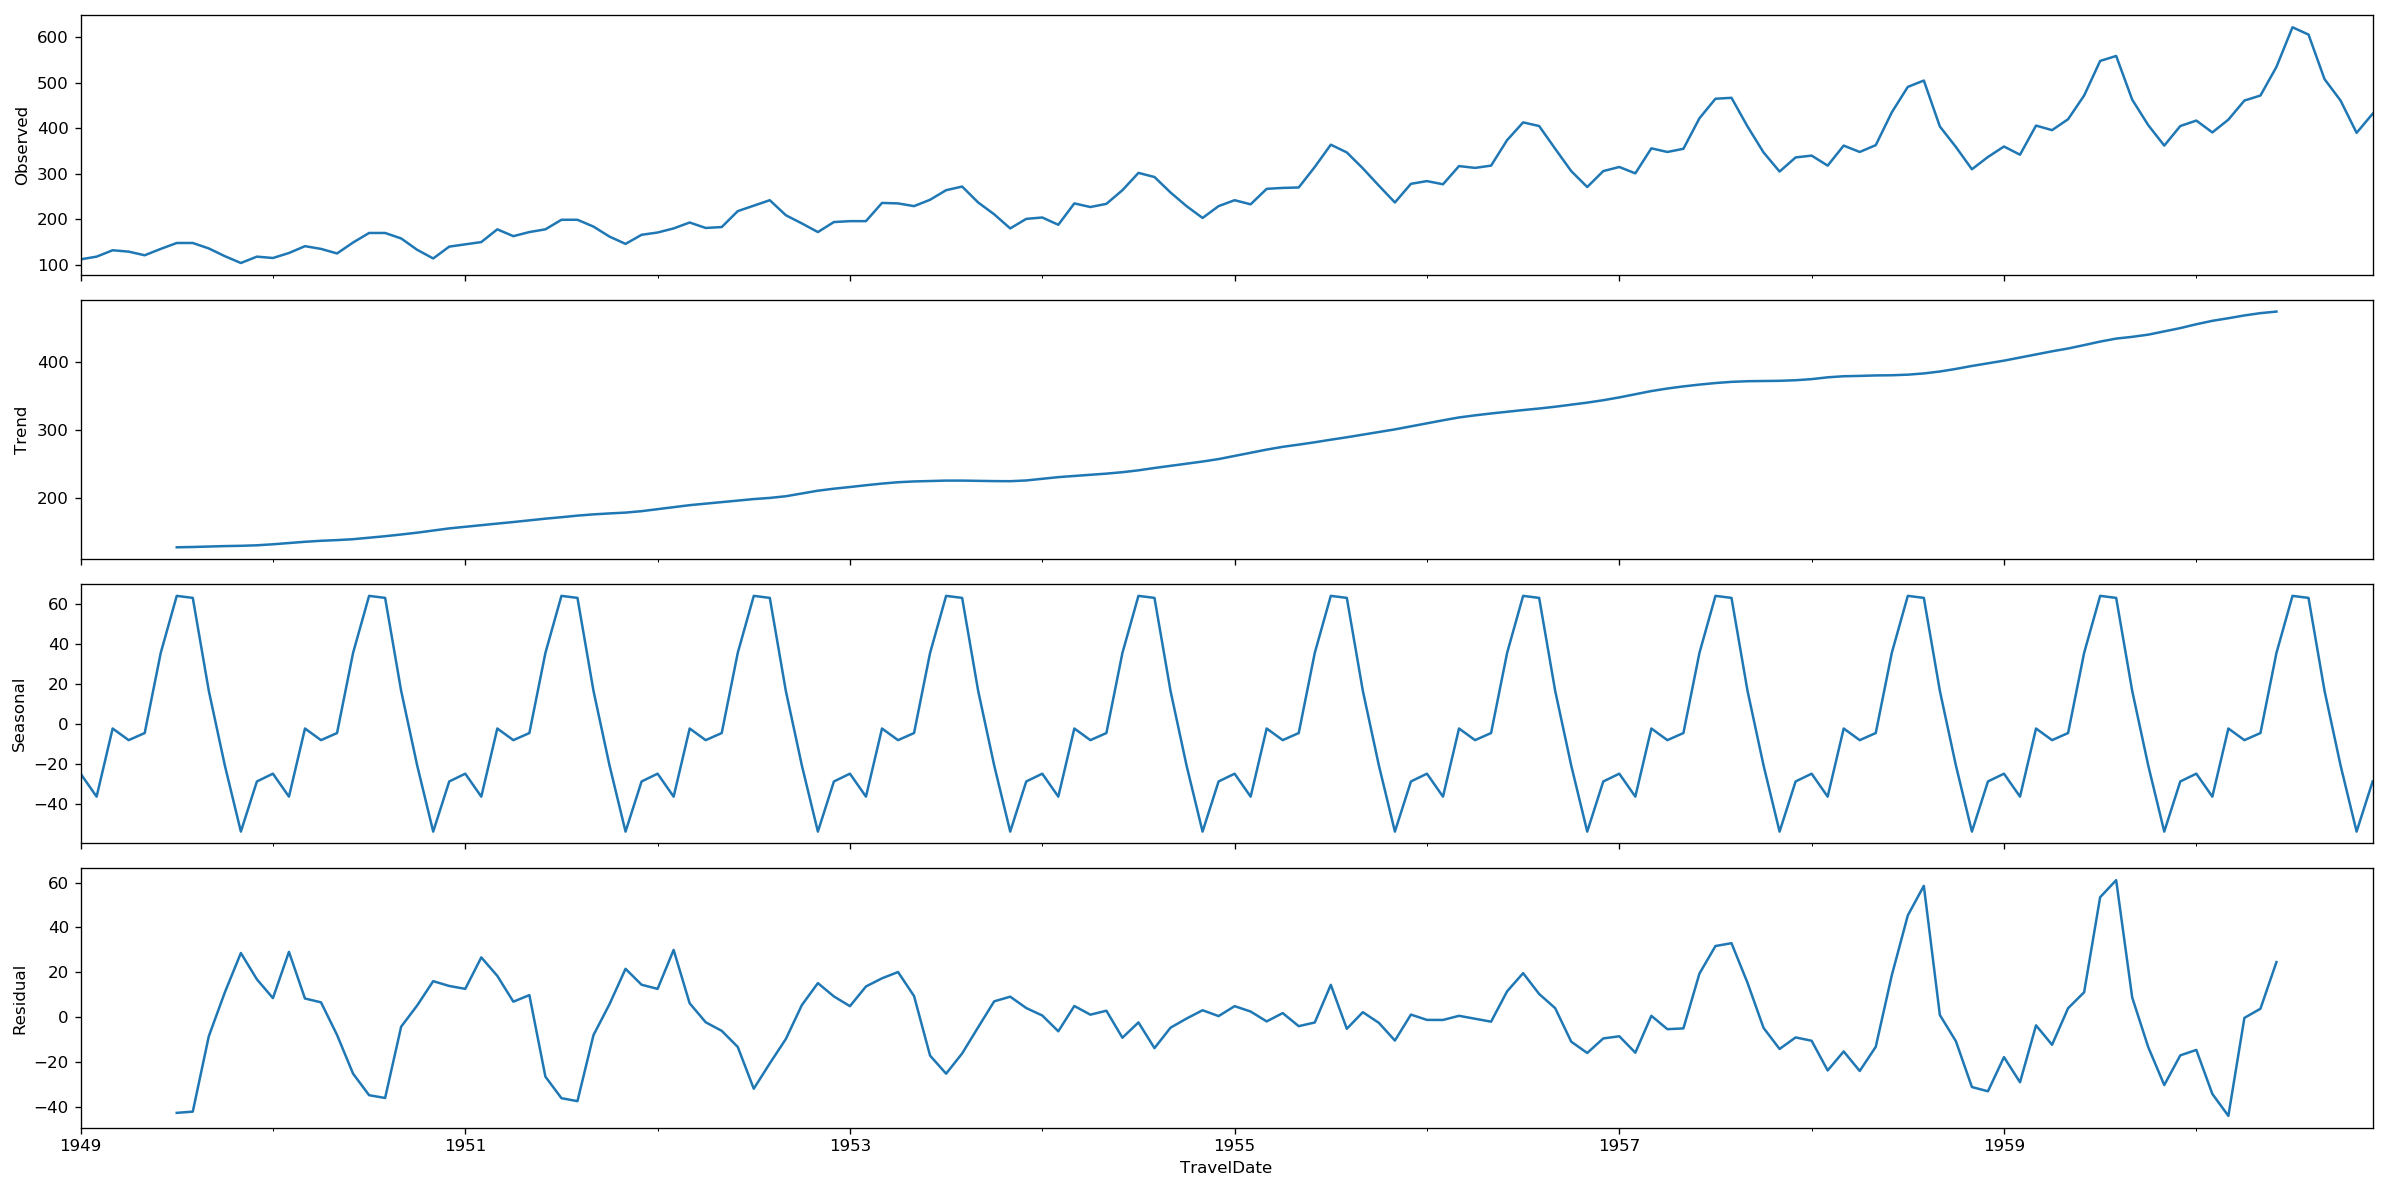

In [148]:
plt.rcParams["figure.figsize"] = (20,10)

decomposition = sm.tsa.seasonal_decompose(airpassengers, model = 'additive')
decomposition.plot();

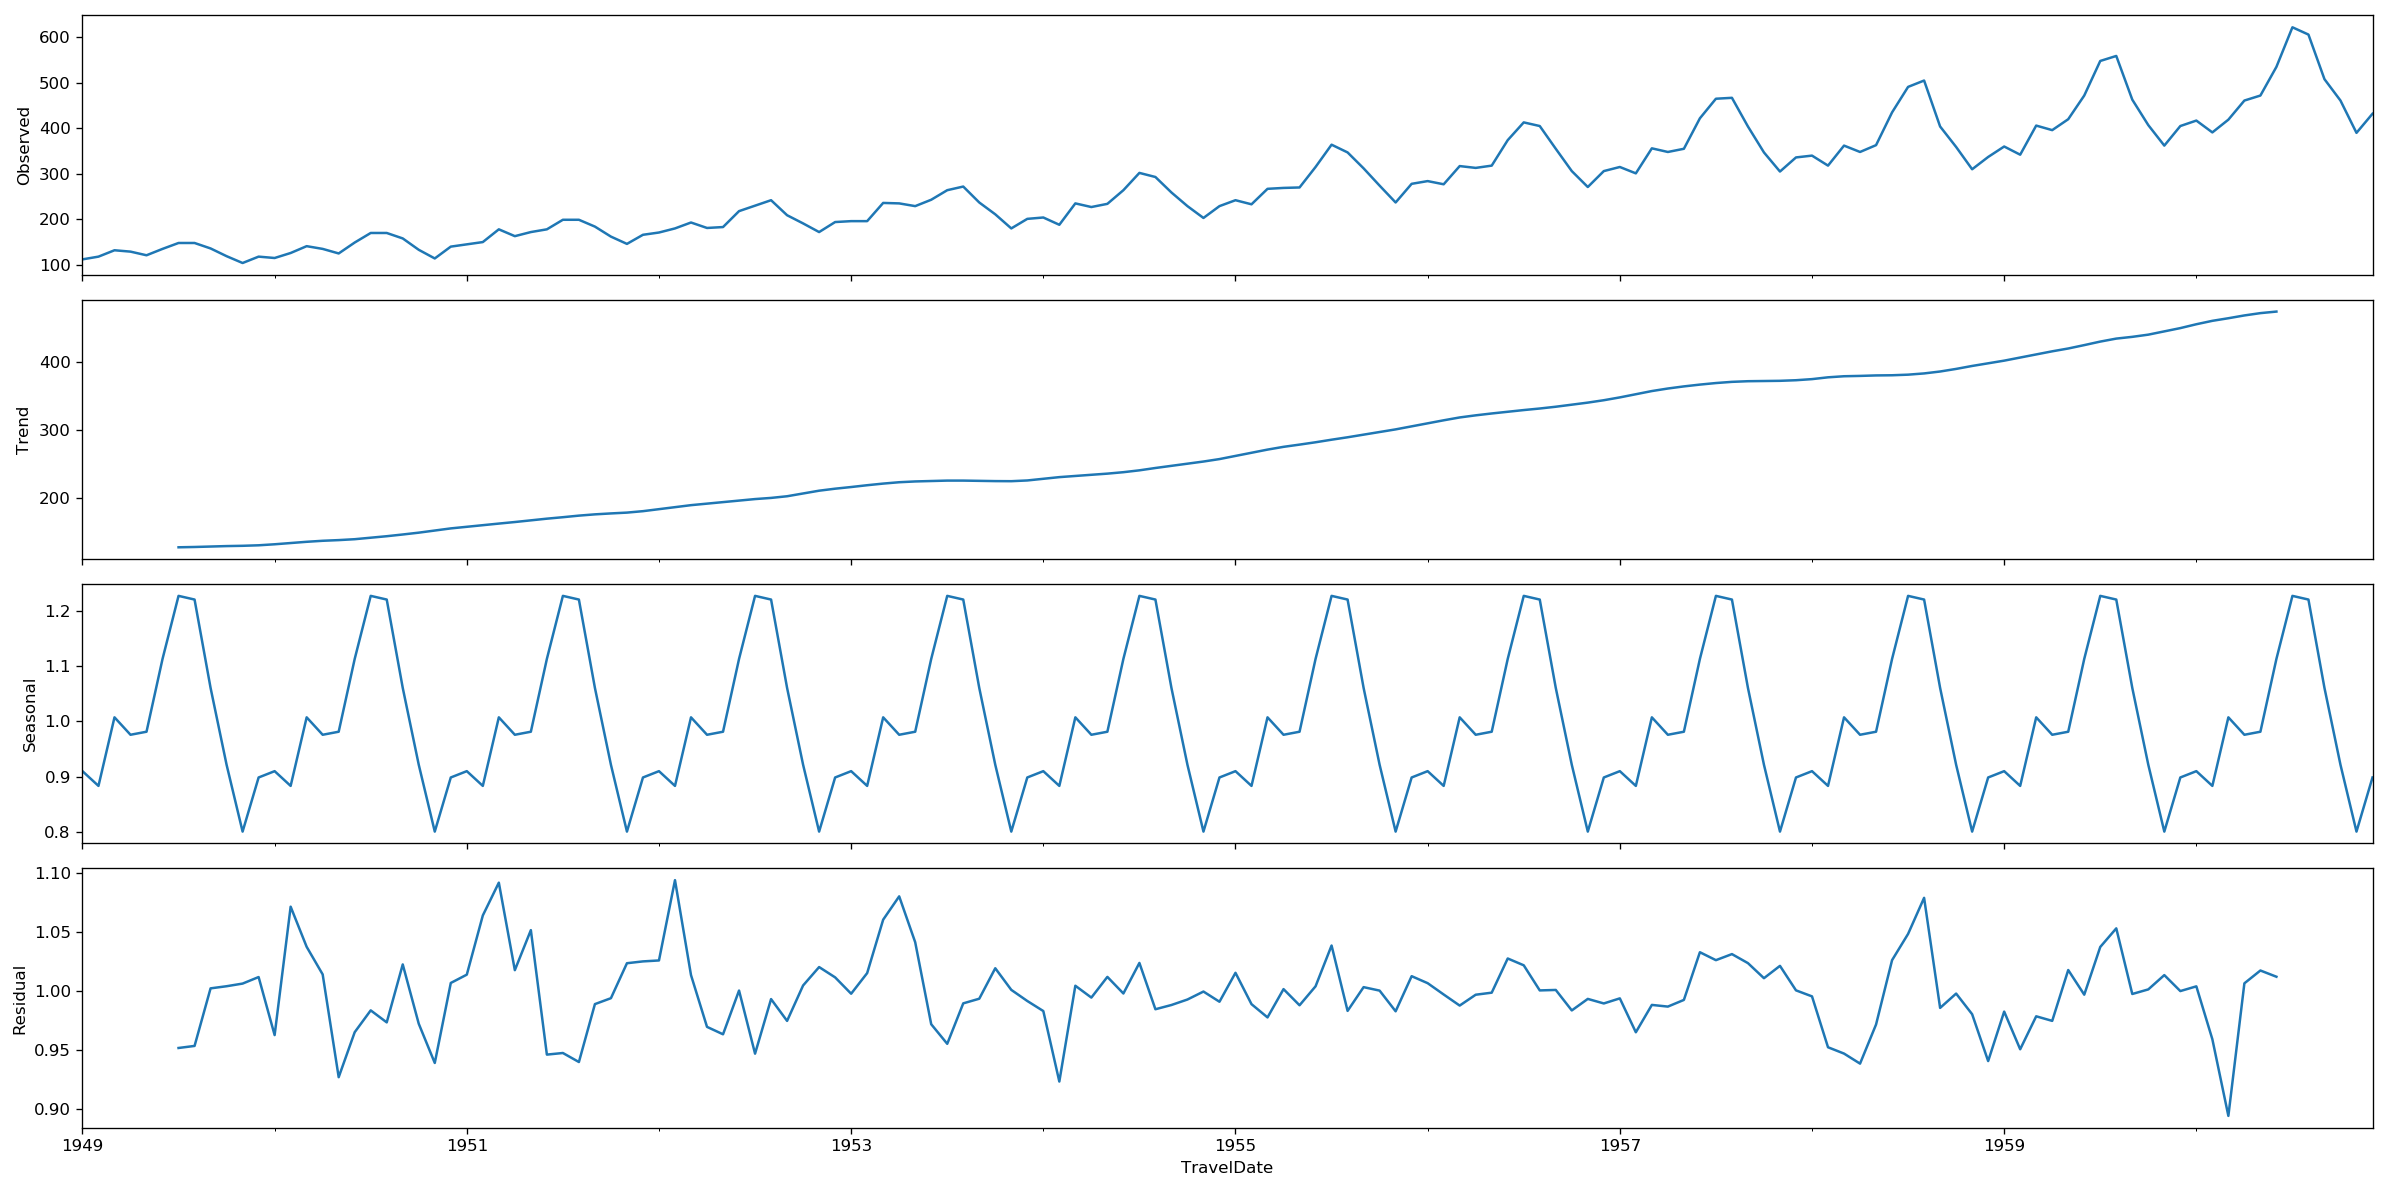

In [149]:
plt.rcParams["figure.figsize"] = (20,10)

decomposition = sm.tsa.seasonal_decompose(airpassengers, model = 'multiplicative')
decomposition.plot();

Nuestra serie es multiplicativa, no estacionaria, tiene una tendencia a la alza y una estacionalidad que parece muy marcada, pero, ¿Qué significa cada cosa?

### Componentes de una serie temporal
El estudio descriptivo de series temporales se basa en la idea de descomponer la variación de una serie en varias componentes básicas. Este enfoque descriptivo consiste en encontrar componentes que correspondan a una tendencia a largo plazo, un comportamiento estacional y una parte aleatoria.

Las componentes o fuentes de variación que se consideran habitualmente son las siguientes:

    - Tendencia: Se puede definir como un cambio a largo plazo que se produce en relación al nivel medio, o el cambio a largo plazo de la media. La tendencia se identifica con un movimiento suave de la serie a largo plazo.

    - Efecto Estacional: Muchas series temporales presentan cierta periodicidad o dicho de otro modo, variación de cierto periodo (anual, mensual ...). Por ejemplo, el paro laboral aumenta en general en invierno y disminuye en verano. Estos tipos de efectos son fáciles de entender y se pueden medir explícitamente o incluso se pueden eliminar del conjunto de los datos, desestacionalizando la serie original.

    - Componente Aleatoria o Residuos: Una vez identificados los componentes anteriores y después de haberlos eliminado, persisten unos valores que son aleatorios. Se pretende estudiar qué tipo de comportamiento aleatorio presentan estos residuos, utilizando algún tipo de modelo probabilístico que los describa. De las tres componentes reseñadas, las dos primeras son componentes determinísticas, mientras que la última es aleatoria. Así, se puede denotar que Xt = Tt + Et + It; donde Tt es la tendencia, Et es la componente estacional, que constituyen la señal o parte determinística, e It es el ruido o parte aleatoria.

In [150]:
# Tras haber hecho la descomposición, podemos acceder a cada uno de nuestros componentes por separado
#decomposition.resid
#decomposition.seasonal
#decomposition.trend
#decomposition.observed

### Autocorrelación

En ocasiones, en una serie de tiempo, pasa que los valores que toma una variable en el tiempo no son independientes entre sí, sino que un valor determinado depende de los valores anteriores.

A la hora de modelar no queremos encontrarnos con autocorrelaciones en nuestra serie porque sesgan los resultados.

Para ver la autocorrelación de nuestra serie utilizamos la ACF y/o la PACF que nos van a servir para determinar cuándo nuestra serie o los resultados de un modelo están viciados o no. De la misma forma y, en una fase más descriptiva nos va a servir para ver si nuestra serie tiene estacionalidad o no:

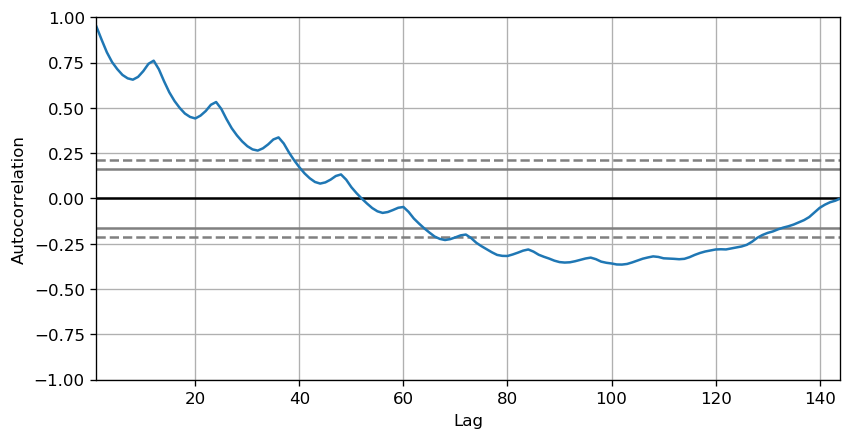

In [151]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
autocorrelation_plot(airpassengers.Passengers.tolist())

En el gráfico podemos ver que se repite un patrón de forma bastante clara, aunque se vaya suavizando. Esto nos indica que existe una estacionalidad en nuestra serie. 

A veces las series tienen una distribución más compleja de sus valores y cuesta ver la estacionalidad en los gráficos, en ese caso (que no se da muchas veces) podemos acudir a test estadísticos cono el 'Ch Test'.

#### En resumen...

Accediendo a los valores podemos ver con mayor detalle la evolución de sus componentes de cara a encontrar patrones interesantes o momentos en el tiempo significativos.

Con estos sencillos pasos podríamos cubrir en gran medida un buen análisis descriptivo de nuestra serie temporal, pero si queremos aplicar predicciones hemos de conocer un poco más sobre ella.

## Clasificación de la serie temporal

Las series temporales se pueden clasificar en:

- **Estacionarias**: Una serie es estacionaria cuando es estable, es decir, cuando la media y la variabilidad son constantes a lo largo del tiempo. Esto se refleja gráficamente en que los valores de la serie tienden a oscilar alrededor de una media constante y la variabilidad con respecto a esa media también permanece constante en el tiempo. Es una serie básicamente estable a lo largo del tiempo, sin que se aprecien aumentos o disminuciones sistemáticos de sus valores. Para este tipo de series tiene sentido conceptos como la media y la varianza. Sin embargo, también es posible aplicar los mismos métodos a series no estacionarias si se transforman previamente en estacionarias.


- **No Estacionarias**: Son series en las cuales la media y/o variabilidad cambian en el tiempo. Los cambios en la media determinan una tendencia a crecer o decrecer a largo plazo, por lo que la serie no oscila alrededor de un valor constante.

![Imagen](https://i.imgur.com/3lKCxEn.png)


Es decir, de cara a hacer pronósticos, necesitamos conocer los componentes de la serie para saber si tenemos que transformarla o no y para saber cómo ajustar los parámetros de nuestro modelo predictivo.

![Imagen2](https://www.machinelearningplus.com/wp-content/uploads/2019/02/stationary-and-non-stationary-time-series.png)

La estacionariedad de una serie se puede establecer observando los plots de la serie como lo hicimos anteriormente.

Otro método es dividir la serie en 2 o más partes contiguas y calcular las estadísticas de resumen como la media, la varianza y la autocorrelación. Si las estadísticas son bastante diferentes, entonces es probable que la serie no sea estacionaria.

Sin embargo, para estar totalmente seguros, necesitamos un método para determinar cuantitativamente si una serie dada es estacionaria o no. Esto se puede hacer mediante pruebas estadísticas llamadas "Pruebas de raíz unitaria". Existen múltiples variaciones de esto, donde las pruebas verifican si una serie de tiempo no es estacionaria y posee una raíz unitaria.

### Pruebas de raíz unitaria

Las dos pruebas de raíz unitaria mas usadas son:

- Prueba Dickey Fuller aumentada (prueba ADF)
- Kwiatkowski-Phillips-Schmidt-Shin - Prueba KPSS (tendencia estacionaria)

La más utilizada es la prueba ADF, donde la hipótesis nula es que la serie temporal posee una raíz unitaria y no es estacionaria. Entonces, si el valor P en la prueba ADH es menor que el nivel de significancia (0.05), rechaza la hipótesis nula.

La prueba KPSS, por otro lado, se usa para probar la estacionariedad de tendencia. La hipótesis nula y la interpretación del valor P es justo lo contrario de la prueba ADH. El siguiente código implementa estas dos pruebas usando el paquete statsmodels en python.

from statsmodels.tsa.stattools import adfuller, kpss

In [152]:
# ADF Test
result = adfuller(airpassengers.Passengers, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


# KPSS Test
result = kpss(airpassengers.Passengers, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 0.8153688792060423
p-value: 0.9918802434376409

KPSS Statistic: 1.052175
p-value: 0.010000


C:\Users\Toni\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning:

p-value is smaller than the indicated p-value



En ambos tests comprobamos que nuestra serie no es estacionaria, por lo que hemos de transformarla para aplicar modelos sobre ella.

### Transformación en estacionaria

Para poder hacer pronósticos de nuestra serie temporal nos vamos a encontrar con que la mayoría de los modelos están construidos en torno a unos supuestos que la serie ha de cumplir. El principal es que la serie sea estacionaria.
Cuando una serie es estacionaria la tendencia y la estacionalidad no están afectando al componente aleatorio, que es el componente que guarda la información más crucial y más 'única' de nuestra serie. Entonces, para convertir una serie en estacionaria (una que no ha pasado los tests de raíz unitaria) simplemente tenemos que reducir o eliminar los componentes de tendencia y estacionalidad hasta que nuestra serie consiga pasar los tests de raíz unitaria.

Hay muchos métodos para transformar una serie en estacionaria (transformación log, transformación de BoxCox, suavizado con medias móviles, trabajando con un ajuste de la estacionalidad...), pero aquí expongo el quizá más utilizado que nos va a servir también para la estimación de parámetros de nuestro modelo.

- **Método de diferenciación**: consiste en suponer que la tendencia evoluciona lentamente en el tiempo, de manera que en el instante t la tendencia debe estar próxima a la tendencia en el instante t − 1. De esta forma, si restamos a cada valor de la serie el valor anterior, la serie resultante estará aproximadamente libre de tendencia. Esta operación se denomina diferenciación de la serie y consiste en pasar de la serie original xt a la serie yt mediante: yt = xt − xt−1


Podemos utilizar funciones como ndiffs o nsdiffs que nos dicen directamente el número de diferenciaciones  que necesita nuestra serie para pasar cada test de raíz unitaria.

In [153]:
#pip install pmdarima
from pmdarima.arima.utils import ndiffs

In [154]:
n_adf = ndiffs(airpassengers, test='adf')
n_adf

0

In [155]:
n_kpss = ndiffs(airpassengers, test='kpss')
n_kpss

1

In [156]:
from pmdarima.arima.utils import nsdiffs

In [157]:
#nsdiffs nos dice el número de diferenciaciones estacionales que necesitamos para pasar el test ch.
n_ch = nsdiffs(airpassengers, m = 12, test='ch')
n_ch

0

Por lo que vemos, necesitamos una diferenciación de factor 1. 

In [160]:
#Aplicamos el método de diferenciación con la función diff() de pandas. 
#Como solo necesitamos diff de factor 1, no ponemos nada en sus parámetros, ya que es la que viene por default
diff1 = airpassengers.Passengers.diff()
diff1.head()

TravelDate
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: Passengers, dtype: float64

In [168]:
#creo el df px para pyplot express
diff1px = diff1.reset_index()
px.line(diff1px.dropna(),x="TravelDate", y="Passengers")

Aquí vemos cómo cambia la serie, suavizando la tendencia y la varianza.

In [169]:
#también cambian sus valores...OJO! el primero siempre va a ser un NaN
diff1.head()

TravelDate
1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Name: Passengers, dtype: float64

Vamos a volver a pasar los tests de raíz unitaria a esta nueva serie para ver si la trnasofrmación ha surtido efecto y es estacionaria. Retiramos los NaN para que no nos dé error.

In [170]:
# ADF Test
result = adfuller(diff1.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


# KPSS Test
result = kpss(diff1.dropna(), regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.8292668241699874
p-value: 0.05421329028382711

KPSS Statistic: 0.053010
p-value: 0.100000


C:\Users\Toni\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value



Ahora sí, nuestra serie es estacionaria y podemos hacer pronósticos con ella.

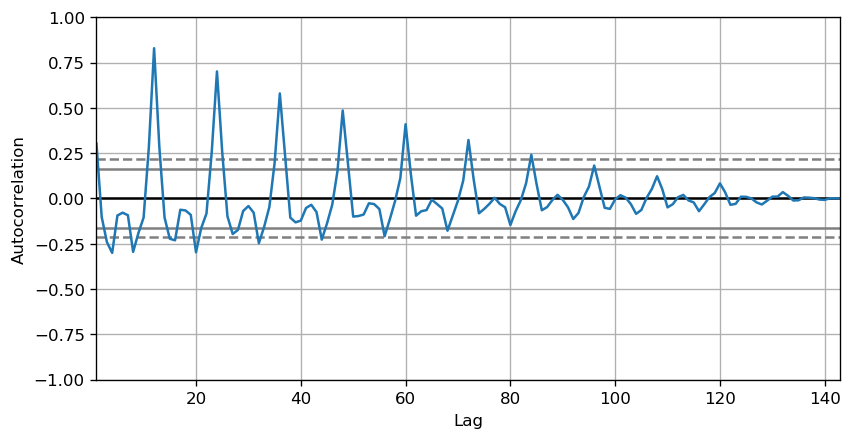

In [171]:
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
autocorrelation_plot(diff1.dropna().tolist())

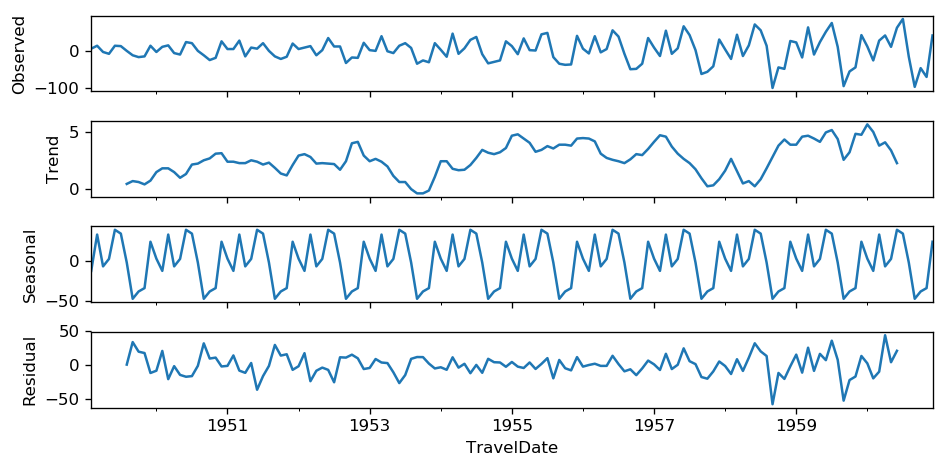

In [172]:
sm.tsa.seasonal_decompose(diff1.dropna()).plot();

## Forecasting con ARIMA

Hay muchos modelos que pueden aplicarse para trabajar con series temporales, siempre depende de las características de nuestra serie temporal y los objetivos que tengamos. Sin embargo, posiblemente el más pulido y utilizado para series temporales sea el modelo ARIMA, que consigue batir casi siempre a modelos mucho más avanzados como las redes neuronales recurrentes.

Hablo desde mi corta experiencia, pro ojo no me pillo los dedos, hay que echarle mucho tiempo de lectura para elegir el modelo que mejor se ajusta a tu problema.

Entonces, ¿qué es exactamente un modelo ARIMA?

**ARIMA**, abreviatura de 'Autoregressive integrated moving average' es en realidad una clase de modelos que 'explica' una serie temporal dada en función de sus propios valores pasados, es decir, en función de sus propios 'lags' (AR) y de los errores de pronóstico de sus valores reales (pasados) respecto de los pronosticados (MA), de modo que se puede usar la ecuación para pronosticar valores futuros.

Cualquier serie de tiempo "no estacional" que muestre patrones y no sea un ruido blanco aleatorio (que no tenga autocorrelación) puede modelarse con los modelos ARIMA.

### ¿Cómo se construye? 3 parámetros: p, d, q

El primer paso para construir un modelo ARIMA es hacer estacionarias las series temporales porque el término "Autoregressive" en ARIMA significa que es un modelo de regresión lineal que usa sus propios lags como predictores. Los modelos de regresión lineal funcionan mejor cuando los predictores no están correlacionados y son independientes entre sí. 

Hemos visto que para hacer una serie estacionaria el metodo más común es el de diferenciación, que va a dar el valor al parámetro 'd'. Por lo que:

- d: es la cantidad de diferenciación requerida para hacer estacionarias las series de tiempo

Mientras que,

- p: es el orden del término "Auto regresivo" (AR). Se refiere al número de lags de Y que se utilizarán como predictores.
- q: es el orden del término "Promedio móvil" (MA). Se refiere a la cantidad de errores de pronóstico pasados que deberían incluirse en el modelo ARIMA.


#### PACF y ACF

Para calcular el parámetro 'p' y 'q' debemos observar los gráficos de la función de autocorrelación parcial y de la autocorrelación, respectivamente. Vamos a verlo con el ejemplo.

C:\Users\Toni\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning:

invalid value encountered in sqrt



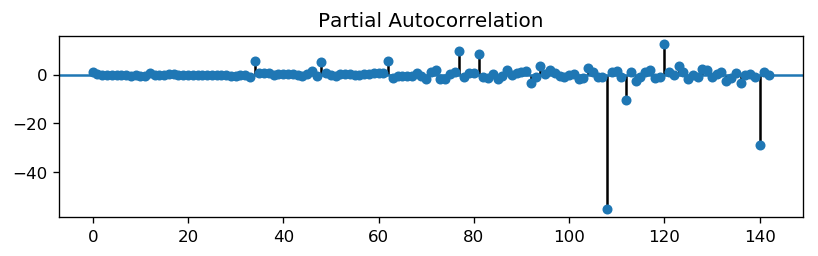

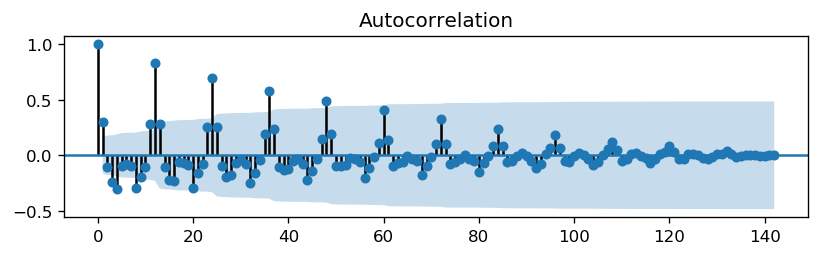

In [173]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(8,2), 'figure.dpi':120})


plot_pacf(diff1.dropna())
plot_acf(diff1.dropna());

En estos gráficos tenemos que contar el número de valores que superan la línea de significancia de forma notable hasta el primer caso que está dentro de la línea de significancia. Siempre vamos a tender a poner el número más bajo posible, ante la duda.

En el caso de nuestro ejemplo, en la función de autocorrelación parcial, el primer lag está ya en la línea de significancia, por lo que nuestro valor de 'p' sería 0.

En la función de autocorrelación podemos ver que el primer lag supera de forma notable la línea de significancia, mientras que el segundo no tanto. Es por esto que yo pondría el valor de 'q' en 1.

Por esto, parece que el modelo que mejor funcionaría para nuestra serie sería un ARIMA (0, 1, 1).

En este caso no estaríamos teniendo en cuenta la estacionalidad que pueda existir (y que requiera un SARIMA) y, además, la estimación de los parámetros de ARIMA a través de gráficos es un poco ambigua y suele llevar a error (al menos en mi caso), por lo que se suele hacer una especie de Grid Search buscando el mejor modelo de todas las combinaciones de parámetros p, d y q (valores de 0-3).

### El truco del almendruco. La función auto_arima

A partir de esta práctica para el cáculo de parámetros algún listo/a crea la función de auto_arima que hace todo esto por nosotros y nos devuelve el mejor modelo.

In [174]:
import pmdarima as pm

model = pm.auto_arima(airpassengers, start_p=0, start_q=0,
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
model.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1032.706, BIC=1041.332, Fit time=0.252 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1033.479, BIC=1039.229, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1022.316, BIC=1033.817, Fit time=0.426 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1022.904, BIC=1034.405, Fit time=0.454 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1022.343, BIC=1030.968, Fit time=0.165 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=1021.142, BIC=1035.518, Fit time=1.234 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1016.960, BIC=1034.211, Fit time=4.586 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1033.371, BIC=1047.747, Fit time=4.307 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=1018.094, BIC=1038.221, Fit time=5.043 seconds
Fit ARIMA: order=(1, 1, 1) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(2, 1, 1, 12)   Log Likelihood                -502.480
Date:                            Mon, 12 Aug 2019   AIC                           1016.960
Time:                                    13:20:53   BIC                           1034.211
Sample:                                         0   HQIC                          1023.970
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0045      0.178      0.025      0.980      -0.345       0.354
ar.L1         -0.3766      0.077     -4.889      0.000      -0.528      -0.226
ar.S.L12       0.6891      0.140      4.916      0.000       0.414       0.964
ar.S.L24       0.3091      0.107      2.884      0.004       0.099       0.519
ma.S.L12      -0.9742      0.512     -1.904      0.057      -1.977       0.029
sigma2       113.2075     48.900      2.315      0.021      17.364     209.051
===================================================================================
Ljung-Box (Q):                       58.67   Jarque-Bera (JB):                12.12
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.70   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El mejor modelo sería un SARIMA (1,1,0)(2,1,1), podemos ir tocando los parámetros de la función para ver si conseguimos uno mejor

### Evaluación del modelo

Para evaluar los modelos en series temporales vamos a ver algunos gráficos que nos muestran si el modelo se comporta sin autocorrelaciones y es extrapolable y nos permite generalizar.

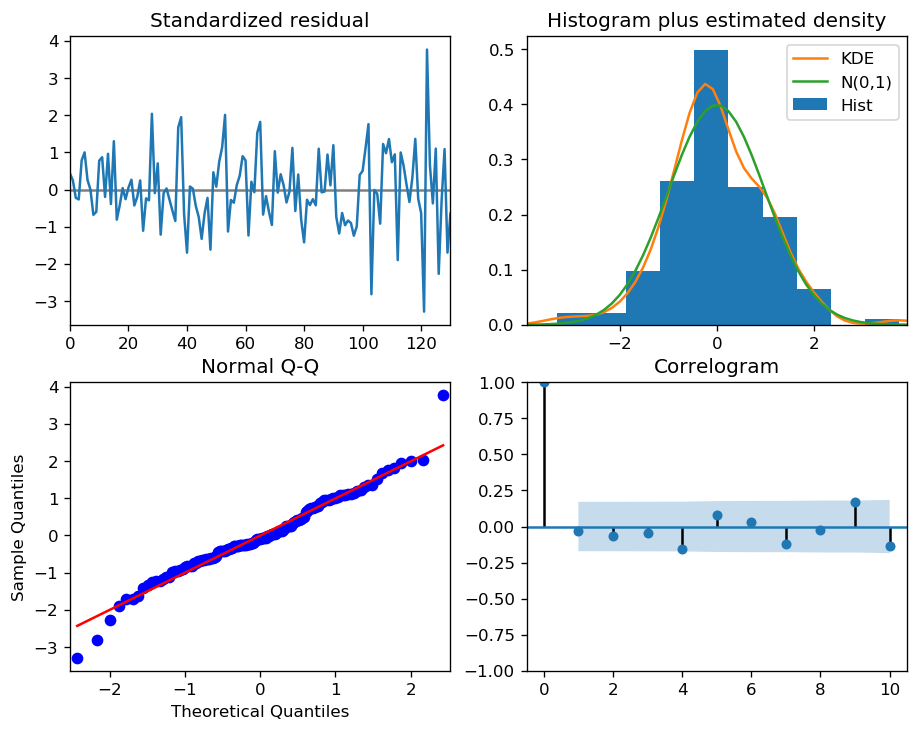

In [175]:
model.plot_diagnostics(figsize=(9,7))
plt.show()

Entonces, ¿cómo interpretar los diagnósticos de los plots?

Arriba a la izquierda: los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza más o menos uniforme.

Arriba a la derecha: la gráfica de densidad sugiere una distribución normal con media cero.

Abajo a la izquierda: todos los puntos deben coincidir perfectamente con la línea roja. Cualquier desviación significativa implicaría que la distribución está sesgada. Casi todos lo hacen en nuestro caso por lo que podría valer.

Abajo a la derecha: el gráfico Correlogram, también conocido como ACF, muestra que los errores residuales no están autocorrelacionados. Cualquier autocorrelación implicaría que hay algún patrón en los errores residuales que no se explican en el modelo. Por lo tanto, deberá buscar más X (predictores) para el modelo. En nuestro caso está perfecto.

En general, parece encajar bien. Vamos a pronosticar. Vamos a ver los pronósticos con la función predict()

In [176]:
model.predict(n_periods = 24)

array([448.86832753, 422.51966258, 463.6420321 , 492.67984489,
       509.75144142, 573.32235415, 663.26429646, 654.75042348,
       549.65503907, 497.19361936, 429.79627663, 474.97360671,
       492.20732303, 462.99499775, 502.09229757, 538.25429744,
       555.50257145, 622.86756051, 718.24171991, 706.54275657,
       595.94305909, 542.50355822, 469.55460095, 516.61556359])

Ploteamos los pronósticos sobre la serie original.

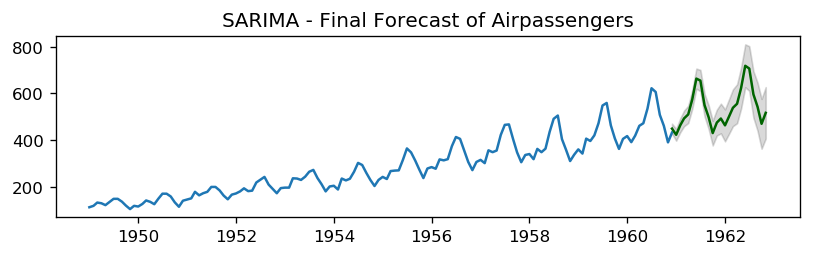

In [177]:
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(airpassengers.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(airpassengers)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Airpassengers")
plt.show()

### Validación cruzada y errores de pronóstico

Cuando hagamos pronósticos con series temporales vamos a trabajar con validación cruzada, esto es dividir la serie en train y test y evaluar el modelo construido sobre train con la parte de test (valores reales).
Para evaluar nuestro modelo vamos a ver los errores de pronóstico que dejan y nos vamos a fijar, sobre todo, en MAPE.

Las métricas comúnmente utilizadas para juzgar los pronósticos son:

Error porcentual absoluto medio (MAPE)
Error medio (ME)
Error absoluto medio (MAE)
Error de porcentaje medio (MPE)
Error cuadrático medio raíz (RMSE)

¿Por qué usar MAPE y no las otras métricas?

Debido a que solo MAPE es un error porcentual que varía entre 0 y 1. De esa manera, puede juzgar qué tan bueno es el pronóstico independientemente de la escala de la serie.

Las otras métricas de error son cantidades. Eso implica que un RMSE de 100 para una serie cuya media está en 1000 es mejor que un RMSE de 5 para series en 10. Por lo tanto, realmente no puede usarlos para comparar los pronósticos de dos series de tiempo escaladas diferentes.

*Ejemplo en punto [10 y 11](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)*

## Lecturas recomendadas

https://otexts.com/fpp3/

https://robjhyndman.com/teaching/

https://support.minitab.com/es-mx/minitab/18/help-and-how-to/modeling-statistics/time-series/supporting-topics/time-series-models/fit-an-arima-model/

https://machinelearningmastery.com/time-series-data-visualization-with-python/

https://www.datascience.com/blog/decomposition-based-approaches-to-time-series-forecasting

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8

https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.machinelearningplus.com/time-series/time-series-analysis-python/

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

https://www.researchgate.net/publication/324889271_An_Introduction_to_Time_Series_Forecasting_with_Python

Biblioteca Prophet de Facebook